## **Heart Disease XGBoost Model**
- XGBoost Model for Heart Disease Classification Complete implementation with hyperparameter tuning.

In [1]:
import pandas as pd

hdb = pd.read_csv(r'/content/output_withml_imputations.csv')

In [2]:
df = hdb.rename(columns = {'dataset': 'location',
                           'num': 'StagesOfHDrisk',
                           'thalch': 'maxHeartRate',
                           'ca': 'coronary arteries',
                           'chol':'cholestrol levels',
                           'cp':'type of chest pain',
                           'fbs':'fasting blood sugar'})
df

,id,age,sex,location,type of chest pain,trestbps,cholestrol levels,fasting blood sugar,restecg,maxHeartRate,exang,oldpeak,slope,coronary arteries,thal,StagesOfHDrisk
0,1,63,Male,Cleveland,typical angina,145.000000,233.0,True,lv hypertrophy,150.000000,False,2.300000,downsloping,0.000000,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.000000,286.0,False,lv hypertrophy,108.000000,True,1.500000,flat,3.000000,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.000000,229.0,False,lv hypertrophy,129.000000,True,2.600000,flat,2.000000,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.000000,250.0,False,normal,187.000000,False,3.500000,downsloping,0.000000,normal,0
4,5,41,Female,Cleveland,atypical angina,130.000000,204.0,False,lv hypertrophy,172.000000,False,1.400000,upsloping,0.000000,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.000000,333.0,True,st-t abnormality,154.000000,False,0.000000,flat,0.917490,normal,1
916,917,62,Male,VA Long Beach,typical angina,149.515465,139.0,False,st-t abnormality,134.606683,True,1.618566,flat,0.879188,reversable defect,0
917,918,55,Male,VA Long Beach,asymptomatic,122.000000,223.0,True,st-t abnormality,100.000000,False,0.000000,flat,1.061530,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,136.601404,385.0,True,lv hypertrophy,135.009535,True,0.692788,flat,0.742459,reversable defect,0


In [3]:
df.isna().sum()

,0
id,0
age,0
sex,0
location,0
type of chest pain,0
trestbps,0
cholestrol levels,0
fasting blood sugar,0
restecg,0
maxHeartRate,0


### **Step 1: Import required libraries and Separate Features & Target**

In [25]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

In [28]:
X = df.drop('StagesOfHDrisk', axis=1)
y = df['StagesOfHDrisk']

In [29]:
num_cols = ['age', 'trestbps', 'cholestrol levels',
            'maxHeartRate', 'oldpeak', 'coronary arteries']

cat_cols = ['type of chest pain', 'restecg', 'slope',
            'thal', 'fasting blood sugar', 'sex', 'exang']

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

### **Optuna**

In [32]:
import optuna

In [33]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "eval_metric": "mlogloss",
        "use_label_encoder": False}

    model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("smote", SMOTE(k_neighbors=2, random_state=42)),
        ("classifier", XGBClassifier(**params))])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1)

    return scores.mean()

In [34]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best Parameters:", study.best_params)
print("Best CV Macro F1:", study.best_value)

[I 2026-02-20 16:33:24,181] A new study created in memory with name: no-name-7168cd59-1dff-4e97-9f70-6b5c453130ea
[I 2026-02-20 16:33:40,866] Trial 0 finished with value: 0.4139886682441352 and parameters: {'n_estimators': 380, 'max_depth': 7, 'learning_rate': 0.019640130378751116, 'subsample': 0.672604902495164, 'colsample_bytree': 0.9863374578022382, 'gamma': 1.7338092199992698, 'min_child_weight': 5}. Best is trial 0 with value: 0.4139886682441352.
[I 2026-02-20 16:33:44,440] Trial 1 finished with value: 0.39557506444645063 and parameters: {'n_estimators': 189, 'max_depth': 7, 'learning_rate': 0.17690317325301824, 'subsample': 0.8095726937000672, 'colsample_bytree': 0.9557551284235434, 'gamma': 0.811688706774848, 'min_child_weight': 7}. Best is trial 0 with value: 0.4139886682441352.
[I 2026-02-20 16:33:51,144] Trial 2 finished with value: 0.39915325545568814 and parameters: {'n_estimators': 286, 'max_depth': 9, 'learning_rate': 0.018102517357822628, 'subsample': 0.608559128295996, 

Best Parameters: {'n_estimators': 231, 'max_depth': 9, 'learning_rate': 0.012612820069550636, 'subsample': 0.9568660279343331, 'colsample_bytree': 0.9359696490367235, 'gamma': 1.1924004786230737, 'min_child_weight': 6}
Best CV Macro F1: 0.42970353967223085


In [35]:
best_params = study.best_params

final_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(k_neighbors=2, random_state=42)),
    ("classifier", XGBClassifier(
        **best_params,
        random_state=42,
        eval_metric="mlogloss",
        use_label_encoder=False))])

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [16:38:46] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [36]:
print("Final Test Macro F1:",
      f1_score(y_test, y_pred, average="macro"))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Final Test Macro F1: 0.36116457835632915

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        82
           1       0.56      0.58      0.57        53
           2       0.19      0.18      0.19        22
           3       0.17      0.19      0.18        21
           4       0.00      0.00      0.00         6

    accuracy                           0.59       184
   macro avg       0.36      0.36      0.36       184
weighted avg       0.60      0.59      0.59       184


Confusion Matrix:
[[69  6  2  5  0]
 [ 7 31  8  5  2]
 [ 1  6  4  8  3]
 [ 0 11  4  4  2]
 [ 0  1  3  2  0]]


In [37]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5869565217391305


In [38]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 Score:', f1)

F1 Score: 0.5946852925860214


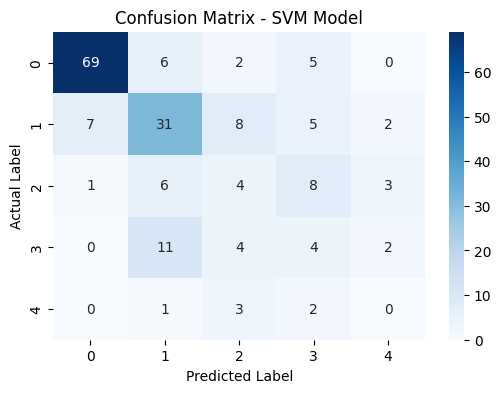

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - SVM Model")
plt.show()

### XIA Predictions:
- Features
- Permutations
- Shap

In [40]:
!pip install shap

In [58]:
import shap
import matplotlib.pyplot as plt, numpy as np, pandas as pd

# Extract trained XGBoost model
xgb_model = final_model.named_steps["classifier"]

# Transform train and test data
X_train_transformed = final_model.named_steps["preprocess"].transform(X_train)
X_test_transformed = final_model.named_steps["preprocess"].transform(X_test)

# Get feature names after preprocessing (important!)
feature_names = final_model.named_steps["preprocess"].get_feature_names_out()

print("Total Features After Encoding:", len(feature_names))

Total Features After Encoding: 25


In [59]:
# SHAP Explainer (TreeExplainer)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

In [60]:
print("SHAP shape:", np.array(shap_values).shape) # o/p - (classes, samples, features)

SHAP shape: (184, 25, 5)


In [61]:
# compute mean feature importance (global importance)

# Convert to numpy array
shap_values_array = np.array(shap_values)

# Take mean absolute SHAP values by averaging over samples (axis=0) and classes (axis=2)
mean_importance = np.abs(shap_values_array).mean(axis=(0, 2))

print("Importance Shape:", mean_importance.shape)
print("Feature Count:", len(feature_names))

Importance Shape: (25,)
Feature Count: 25


In [63]:
mean_importance = np.abs(shap_values_array).mean(axis=0).mean(axis=1)

Explanation:

mean(axis=0) → average over samples → (features, classes)

mean(axis=1) → average over classes → (features,)

In [64]:
print(mean_importance.shape)
print(len(feature_names))

(25,)
25


In [57]:
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": mean_importance
}).sort_values(by="Importance", ascending=False)

print(feature_importance.head(15))

                                 Feature  Importance
5                 num__coronary arteries    0.361245
4                           num__oldpeak    0.189402
6   cat__type of chest pain_asymptomatic    0.148801
17                      cat__thal_normal    0.133649
0                               num__age    0.104842
2                 num__cholestrol levels    0.091669
1                          num__trestbps    0.086579
3                      num__maxHeartRate    0.076564
10           cat__restecg_lv hypertrophy    0.070377
23                      cat__exang_False    0.068629
19        cat__fasting blood sugar_False    0.053178
14                       cat__slope_flat    0.052647
11                   cat__restecg_normal    0.049702
15                  cat__slope_upsloping    0.046696
18           cat__thal_reversable defect    0.032345
